# LINEAR REGRESSION

The general problem to solve is

\begin{equation*}
y_{i} = \sum^n_j x_{ij}\beta_j
\end{equation*}

or in matrix form,

\begin{equation*}
\mathbf{y} = \mathbf{X}\beta
\end{equation*}

We assume for simplicity that $y$, the regressand, is one-dimensional. That is, we are trying to learn a single property with some set of training data of length $n$ (denoted by index $i$). Typically we have a set of descriptors that relate features that we can define arbitarily with the properties we are trying to learn. Each descriptor is itself a vector of length $m$ (denoted by the index $j$). $x$ is a matrix that contains the descriptors for each instance in the training set, and $\beta$ is the set of weights that we wish to learn. If a bias is expected, then the length of $n$ can be increased by one and a padding is added to $x$ of constants (setting this to one will mean that the corresponding $\beta_j$ for this extra descriptor represents the predicted value of the bias). 


### OLS estimator
One can solve for a simple prediction of beta analytically with the following expression,

\begin{equation*}
\hat{\beta} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}
\end{equation*}

In this instance, the only thing to then optimize is the number of input parameters for the size of training data that we have. 

### Atomic Descriptors
The descriptors are taken from the atomic positions, and are defined by combining knowledge of the soft-sphere interface constructed from the atoms, with the local neighbourhood described in a way that is currently agnostic of atomic species, but is translationally and rotationally invariant. The result is an infinite series of angular descriptors that can be limited by an intelligently set cutoff parameter and some maximum $n$ and $l$ values (which are more difficult to determine). 

To use these descriptors to predict molecular properties, one needs to combine them in a way that makes sense. A simple summation over all the atoms seems to work in this case, under the assumption that the learned property is additive (note that this may limit how well the model will be able to predict the desired properties). 

For simple OLS linear regression, the primary factor that limits the number of descriptors that can be used to effectively predict the cavitation energy seems to be the number of training points. Clearly we want more descriptors but there is a limit. It's quite possible that some of this is due to multicollinearity, something that can be verified by regularization (see ridge regression)

### Ridge Regression
To improve cases in which we have large numbers of parameters, a ridge parameter can be added. The following assumes again that we can estimate the problem analytically,

\begin{equation*}
\hat{\beta} = (\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}
\end{equation*}

Note that in the limit that $\lambda \to 0$, this reduces to simple linear regression. We can now compare the MAE (mean absolute error) of different values of $\lambda$, nmax, and lmax. Note that finding $\lambda$ should be an optimization problem but it's quite difficult due to the apparent behaviour of the function, and therefore we'll leave it until later once we have a better idea of the nature of this function.

### Learning the Cavitation Energy
Since the cavitation energy can be quite well approximated by the surface area, it should be reasonable to split the task into two steps. One to fit the surface area to the energy, and another to fit any corrections from the positional data. One can argue that this is a valid approach since the correction can be thought of as the effect of the solvent's ability to structure itself around the cavity, so that different shapes of equivalent surface area would have different cavitation energy values. 

The following fits this correction factor. The MAE surface represents the mean average error after the OLS linear regression fitting for the surface term (note that this is not exactly comparable to the final MAE, since it is not obtained via an equivalent cross validation, however, the results from such a cross validation method are given first for proper comparison). The Final MAE is the mean average error after the corrections have been made. This value is determined by cross-validation. The goal is to clearly minimize this value, and have it less than the initial MAE from the surface, which suggests that the positional data can correctly learn the deviations. From there, the question is how far we can get, by exploring a greater number of descriptors and using more data.

Clearly, the increased descriptors incur multicollinearlity issues. The hope is that ridge regression can compensate for these.

number of descriptors 21


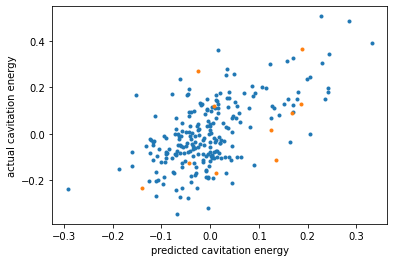

MAE:  0.46362271567059593


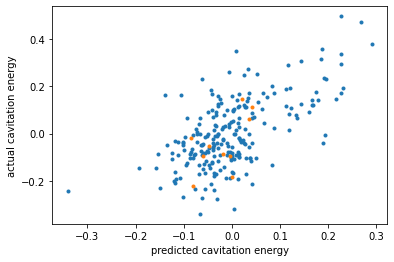

MAE:  0.26709465385397896


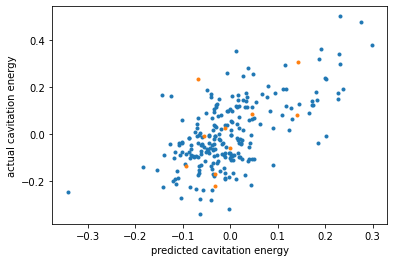

MAE:  0.3506272801391837


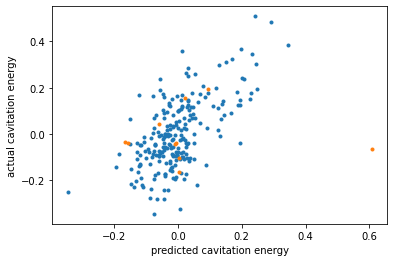

MAE:  0.5137382267777115


MAE:  0.4122050533394255


MAE:  0.34096424741413334


MAE:  0.13950090711390917


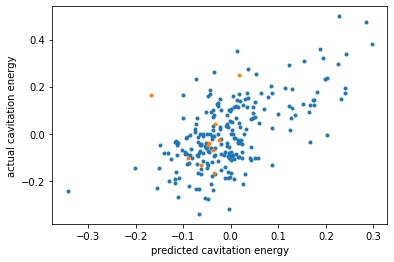

MAE:  0.29088766490971973


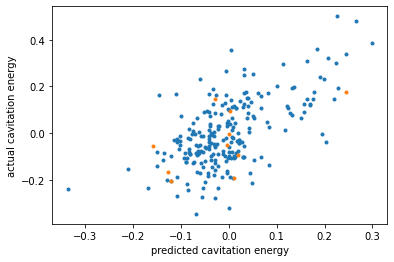

MAE:  0.3049642082383662


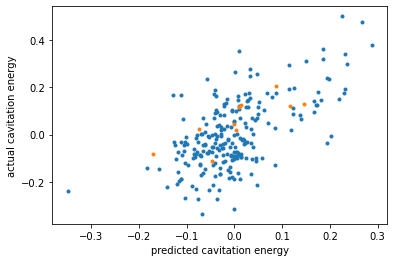

MAE:  0.219555150630706


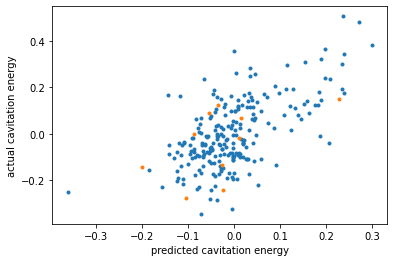

MAE:  0.35741422427741976


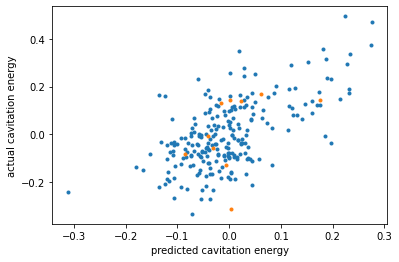

MAE:  0.3472573896028488


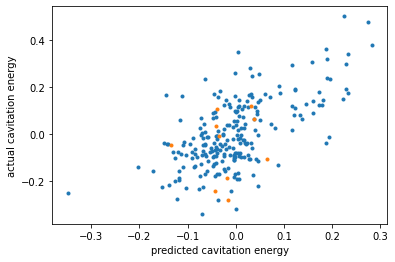

MAE:  0.405763314422939


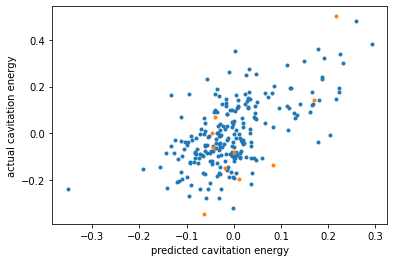

MAE:  0.45355269900608336


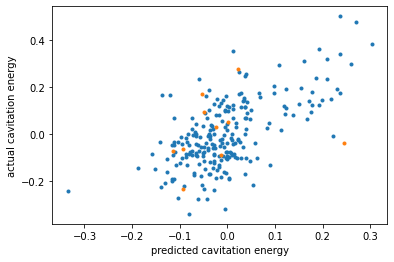

MAE:  0.4227780899061041


MAE:  0.32694614686173673


MAE:  0.25911167464432294


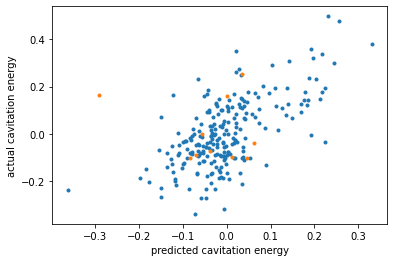

MAE:  0.4330527102867529


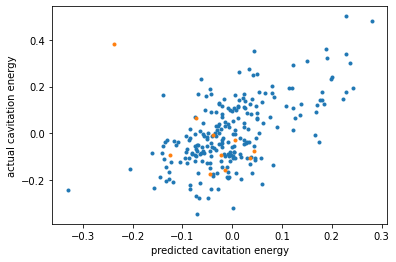

MAE:  0.4731578339584759


MAE:  0.27240892202499234


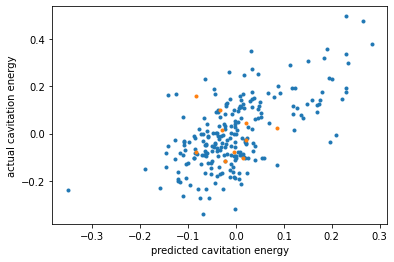

MAE:  0.2784856519018093


MAE:  0.28891031769368736


MAE:  0.324001912529012


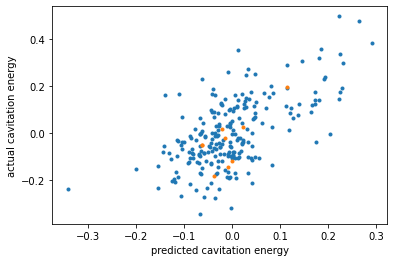

MAE:  0.1993749374959311
FINAL MAE 0.33939066386249356


In [4]:
from numpy.linalg.linalg import norm
from regression.learning.linear import LinearRegression
from regression.learning.ridge import RidgeRegression
from regression.utility.distribute import get_indices
from regression.utility.descriptor import *
from regression.parsing.molecule import read_molecular_data
import numpy as np

# seed for testing purposes
training_size = 229
testing_size = 10
n = 4
l = 2
full_size = training_size + testing_size
input_dir_location = '../input'
set_list = ['S1']

# read in molecule
full_set = read_molecular_data(input_dir_location, set_list, n_max=n, l_max=l)

base = LinearRegression("surface")

# perform ordinary least squares algorithm
i = 0
mae = []
ridge = RidgeRegression("atomic_environment")
ridge.lagrange = 0.0
while i <= full_size-1:
    indices = get_indices(full_size, testing_size, i)
    save_descriptor(full_set)
    translate, scale = cs_normalize_atomic(full_set, **indices)
    scale *= 418.4 # UNITS FROM 10J->kcal
    beta_b = base.get_params(full_set, plot=False, **indices)
    for m in full_set:
        m.output = m.output - m.features["surface"] @ beta_b
    beta = ridge.get_params(full_set, plot=False, **indices)
    if i == 0:
        print("number of descriptors", beta.shape[0])
    ridge.update_prediction(full_set, plot=True, **indices)
    obj = ridge.get_objective(full_set, **indices)
    print("MAE: ", obj / scale)
    if i == iview * testing_size:
        quit()
    mae.append(obj / scale)
    i += testing_size
    load_descriptor(full_set)

print("FINAL MAE", sum(mae)/len(mae))


This can be further minimized by playing with the lagrange multiplier. 

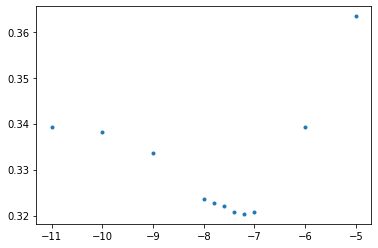

In [5]:
log_lagrange = [-11, -10, -9, -8, -7.8, -7.6, -7.4, -7.2, -7, -6, -5]
mae = [0.33919936611709595, 0.3380828769568675, 0.33359263164557573, 0.32362475976101734, 
       0.32273187766300115, 0.3220139894250174, 0.3208388845905495, 0.3203493598476101,
       0.3207984711123944, 0.33935433082623123, 0.3633818232776546]
import matplotlib.pyplot as plt
plt.plot(log_lagrange, mae, '.')
plt.show()

For a larger set of descriptors, linear regression performs worse, but the regularization techniques might ameliorate this.

surface_MAE = 0.38053542608942004
ndescriptors = 41
final MAE = 0.5342967491224634

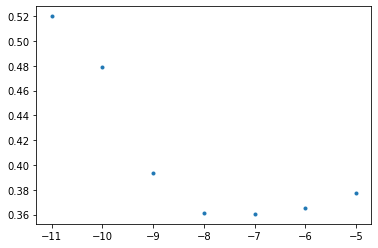

In [6]:
log_lagrange = [-11, -10, -9, -8, -7, -6, -5]
mae = [0.5198624205016348, 0.4788197724647673, 0.39319453925581377, 0.36141712737687864, 0.360522236336222,
      0.3652588994307641, 0.37720700205358254]
import matplotlib.pyplot as plt
plt.plot(log_lagrange, mae, '.')
plt.show()